# **IMPORT LIBRRARY**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
# !pip install feature-engine
from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as imbpipe
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# !pip install shap==0.44.0
import shap

import warnings
warnings.filterwarnings(action='ignore')

# **DATA LOADING AND OVERVIEW**

dataset link: [kaggle](https://www.kaggle.com/datasets/laotse/credit-risk-dataset)

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rafifaditio/Data/main/credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
df.shape

(32581, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
df[df.duplicated()].shape

(165, 12)

In [6]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [7]:
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

for i in cat_cols:
  print(i)
  print(df[i].value_counts())
  print('-'*10)

person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: person_home_ownership, dtype: int64
----------
loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: loan_intent, dtype: int64
----------
loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: loan_grade, dtype: int64
----------
cb_person_default_on_file
N    26836
Y     5745
Name: cb_person_default_on_file, dtype: int64
----------


In [8]:
df['loan_status'].value_counts(normalize=True)

0    0.781836
1    0.218164
Name: loan_status, dtype: float64

In [9]:
num_cols = df.describe().columns.to_list()

df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


Data Overview Notes:
- Missing value consist in person_emp_length (895) and loan_int_rate (3116)
- There are 165 duplicated data
- There are anomalies in person_age (max: 144) and person_emp_length (max: 123)

# **CLEANING**

In [10]:
# rename columns
df.rename(columns={'person_age':'age', 'person_income': 'income',
                   'person_home_ownership':'home_ownership',
                   'loan_status':'loan_default',
                   'cb_person_default_on_file':'hist_default',
                   'cb_person_cred_hist_length':'cred_hist_length'},
          inplace=True)

In [11]:
# drop duplicates
df.drop_duplicates(inplace=True)

# **EDA**

**preview**

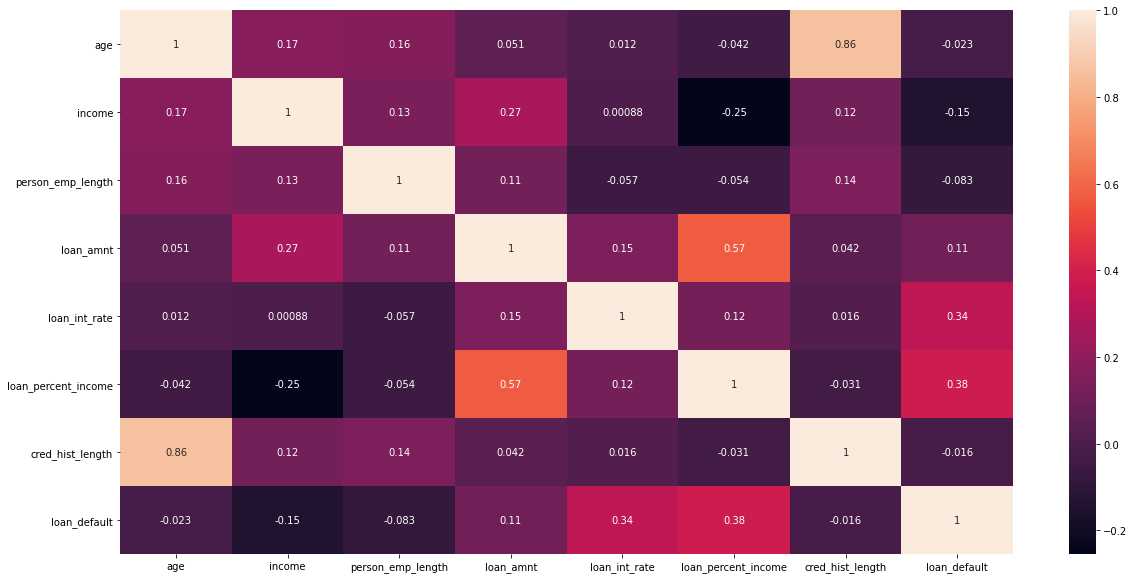

In [12]:
num_cols = ['age', 'income','person_emp_length',
            'loan_amnt','loan_int_rate',
            'loan_percent_income','cred_hist_length',
            'loan_default']

fig,ax = plt.subplots(figsize=[20,10])

corr = df[num_cols].corr()

ax = sns.heatmap(corr,annot=True)
plt.show()

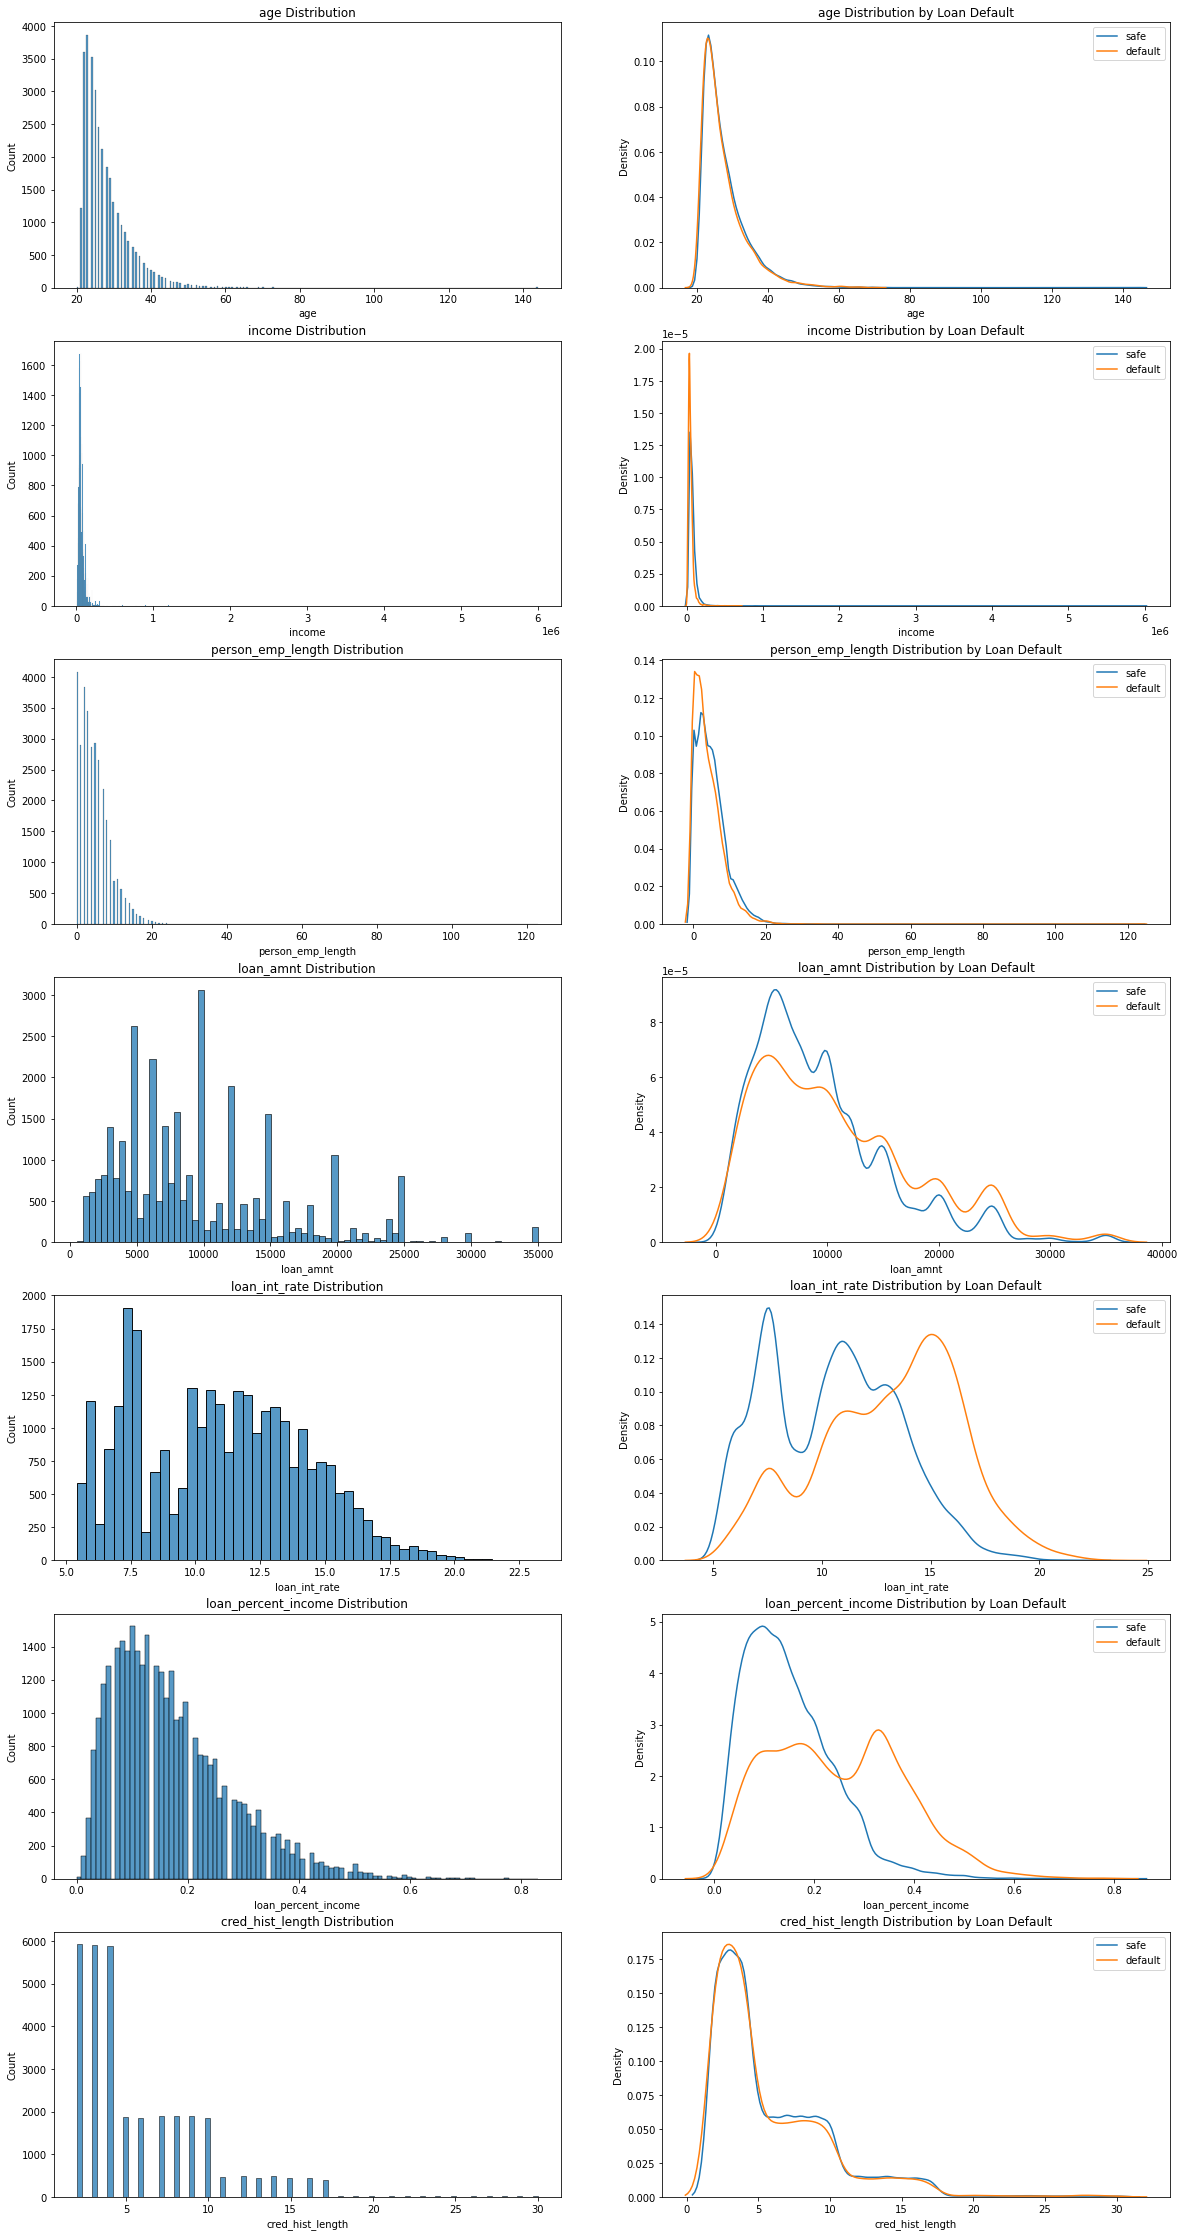

In [13]:
num_cols = ['age', 'income','person_emp_length',
            'loan_amnt','loan_int_rate',
            'loan_percent_income','cred_hist_length']

fig,ax = plt.subplots(nrows=7, ncols=2, figsize=[20,40])
ax = ax.flatten()

for i, col in enumerate(num_cols):
  i = i*2
  sns.histplot(df[col], ax=ax[i])
  sns.kdeplot(df[df['loan_default']==0][col], ax=ax[i+1], label='safe')
  ax[i].set_title(f'{col} Distribution')
  sns.kdeplot(df[df['loan_default']==1][col], ax=ax[i+1], label='default')
  ax[i+1].set_title(f'{col} Distribution by Loan Default')
  ax[i+1].legend()

- loan_amount, > 12000 default
- loan interest rate, > 13% default
- loan percent income, > 0.2 default

## Categorical EDA

In [14]:
def perc_bar(x,y):
  df1 = df.groupby(x)[y].value_counts(normalize=True)
  df1 = df1.mul(100)
  df1 = df1.rename('percent').reset_index()

  g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
  g.ax.set_ylim(0,100)

  for p in g.ax.patches:
      txt = str(np.round(p.get_height(),2)) + '%'
      txt_x = p.get_x()
      txt_y = p.get_height()
      g.ax.text(txt_x,txt_y+1,txt)

  plt.xticks(rotation=45)

def count_bar(x):
  orders = sorted(df[x].unique().tolist())
  ax = sns.countplot(data=df, x=x, hue='loan_default', order=orders)

  for i in ax.containers:
      ax.bar_label(i,)

  plt.xticks(rotation=45)

### **home ownership**

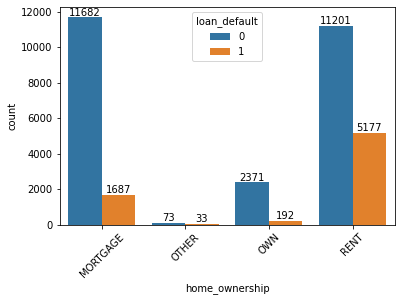

In [15]:
count_bar('home_ownership')

In [16]:
33/(73+33)*100

31.132075471698112

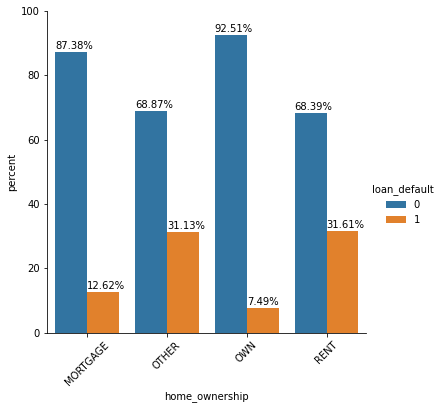

In [17]:
perc_bar('home_ownership', 'loan_default')

### **loan intention**

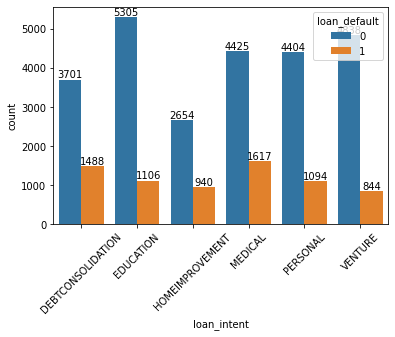

In [18]:
count_bar('loan_intent')

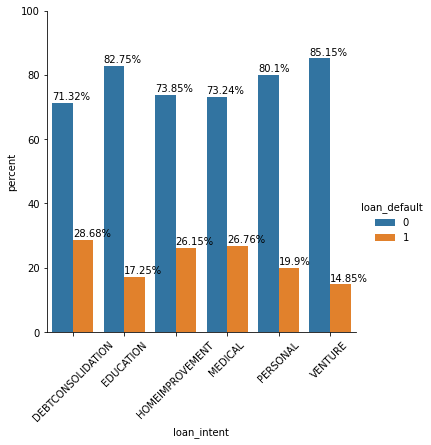

In [19]:
perc_bar('loan_intent', 'loan_default')

### **loan grade**

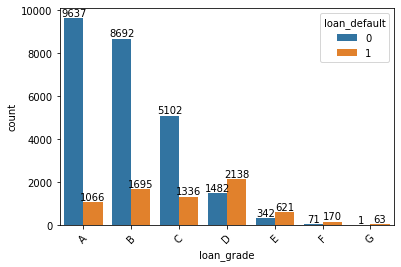

In [20]:
count_bar('loan_grade')

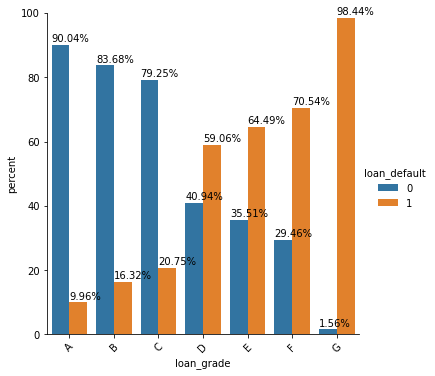

In [21]:
perc_bar('loan_grade', 'loan_default')

In [22]:
# separate grade DEFG and ABC
df['loan_grade_group'] = ['DEFG' if i in ['D','E','F','G'] else 'ABC' for i in df['loan_grade']]
# df[['loan_grade', 'loan_grade_group', 'loan_default']]

In [23]:
# separate DEFG deafult and DEFG safe
defg_default = df[(df['loan_grade_group']=='DEFG') & (df['loan_default']==1)]
defg_safe = df[(df['loan_grade_group']=='DEFG') & (df['loan_default']==0)]

print(defg_default.shape)
print(defg_safe.shape)

(2992, 13)
(1896, 13)


In [24]:
sum(defg_default['loan_amnt'])

34201325

In [25]:
print('sum of loan in DEFG grade safe loan: ', sum(defg_safe['loan_amnt']))
print('mean of loan intereset in DEFG grade safe loan: ', np.round(np.mean(defg_safe['loan_int_rate']),2), '%')
print('interest from loan: ', sum(defg_safe['loan_amnt']) * np.mean(defg_safe['loan_int_rate'])/100)

sum of loan in DEFG grade safe loan:  22185800
mean of loan intereset in DEFG grade safe loan:  15.81 %
interest from loan:  3507010.6270945156


In [26]:
# mean and median of interest rate on each loan grade
df.groupby('loan_grade').agg({'loan_int_rate':['mean','median'],
                              'loan_amnt':['mean','median'],
                              'loan_percent_income':['mean','median'],
                              'income':['mean','median']})

loan_int_rate             loan_amnt          loan_percent_income  \
                    mean  median          mean   median                mean   
loan_grade                                                                    
A               7.328423   7.490   8545.702140   7500.0            0.153757   
B              10.995756  10.990   9992.228266   8400.0            0.175283   
C              13.464579  13.480   9219.175210   8000.0            0.170098   
D              15.360698  15.310  10855.759669   9000.0            0.190981   
E              17.008409  16.820  12919.911734  12000.0            0.206106   
F              18.609159  18.535  14717.323651  15000.0            0.215643   
G              20.251525  20.160  17195.703125  19375.0            0.243906   

                         income           
           median          mean   median  
loan_grade                                
A           0.130  66605.836121  57600.0  
B           0.150  66332.369789  55000.0  
C           0.150  64963.895464  53000.0  
D           0.170  63703.096961  54000.0  
E           0.190  70856.360332  59160.0  
F           0.210  77008.730290  65000.0  
G           0.255  76773.296875  66900.0

- loan_amount, > 12000 default
- loan interest rate, > 13% default
- loan percent income, > 0.2 default

In [27]:
defg_default.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2992.0,27.765709,6.452790,20.00,23.00,26.00,30.00,70.00
income,2992.0,58115.038436,43164.540154,4200.00,33000.00,49000.00,69000.00,703800.00
person_emp_length,2927.0,3.948753,4.501398,0.00,1.00,3.00,6.00,123.00
loan_amnt,2992.0,11430.924131,7677.620989,1000.00,5000.00,9975.00,16000.00,35000.00
loan_int_rate,2748.0,15.967675,1.625668,6.00,14.91,15.68,16.77,23.22
loan_default,2992.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.00
loan_percent_income,2992.0,0.213670,0.118904,0.01,0.12,0.19,0.29,0.70
cred_hist_length,2992.0,5.810829,4.197360,2.00,3.00,4.00,8.00,30.00


there are difference descriptive value in: income, person_emp_length, loan_percent_income

In [28]:
defg_safe.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1896.0,28.121835,6.327177,20.00,24.00,26.00,31.00,69.00
income,1896.0,78287.070675,55027.305507,12000.00,45354.00,65000.00,94035.00,600000.00
person_emp_length,1874.0,5.706510,4.036577,0.00,3.00,5.00,8.00,31.00
loan_amnt,1896.0,11701.371308,7295.394287,1000.00,6000.00,10000.00,15000.00,35000.00
loan_int_rate,1714.0,15.807456,1.437162,6.00,14.91,15.65,16.49,22.06
loan_default,1896.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
loan_percent_income,1896.0,0.167780,0.089165,0.01,0.10,0.16,0.23,0.64
cred_hist_length,1896.0,6.044831,4.154356,2.00,3.00,4.00,8.00,30.00


### **historical default**

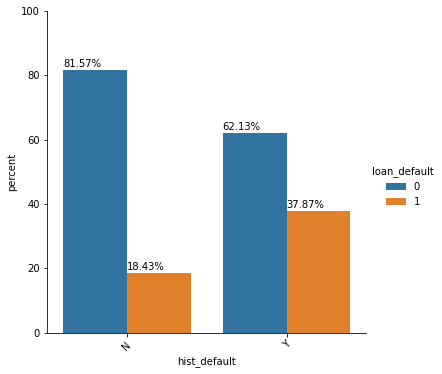

In [29]:
perc_bar('hist_default', 'loan_default')

# **Preprocess for Model**

In [30]:
# split
X = df.drop('loan_default', axis=1)
y = df.loan_default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(22691, 12)
(9725, 12)
(22691,)
(9725,)


## **numerical**

In [31]:
num_cols

['age',
 'income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cred_hist_length']

In [32]:
imp = SimpleImputer(strategy='median')
X_train_num = imp.fit_transform(X_train[num_cols])
X_test_num = imp.transform(X_test[num_cols])

In [33]:
scaler = StandardScaler()
X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_cols)
X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=num_cols)

## **categorical columns**

In [34]:
cat_cols = ['home_ownership', 'loan_grade', 'hist_default', 'loan_intent']

for i in cat_cols:
  print(i)
  print(X_train[i].value_counts())
  print('-'*10)

home_ownership
RENT        11446
MORTGAGE     9382
OWN          1788
OTHER          75
Name: home_ownership, dtype: int64
----------
loan_grade
A    7425
B    7353
C    4515
D    2508
E     681
F     169
G      40
Name: loan_grade, dtype: int64
----------
hist_default
N    18720
Y     3971
Name: hist_default, dtype: int64
----------
loan_intent
EDUCATION            4531
MEDICAL              4279
VENTURE              3993
PERSONAL             3809
DEBTCONSOLIDATION    3611
HOMEIMPROVEMENT      2468
Name: loan_intent, dtype: int64
----------


In [35]:
np.sort(X_train['hist_default'].unique())

array(['N', 'Y'], dtype=object)

In [36]:
ord_col = ['home_ownership', 'loan_grade', 'hist_default']
ohe_col = ['loan_intent']

In [37]:
ord = OrdinalEncoder(categories=[['OTHER', 'RENT', 'OWN', 'MORTGAGE'],
                                 ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
                                 ['N', 'Y']])
X_train_ord = pd.DataFrame(ord.fit_transform(X_train[ord_col]), columns=ord_col)
X_test_ord = pd.DataFrame(ord.transform(X_test[ord_col]), columns=ord_col)

In [38]:
ohe = OneHotEncoder(sparse=False)
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[ohe_col]))
X_train_ohe.columns = ohe.get_feature_names_out(['loan_intent']).tolist()

X_test_ohe = pd.DataFrame(ohe.transform(X_test[ohe_col]))
X_test_ohe.columns = ohe.get_feature_names_out(['loan_intent']).tolist()

In [39]:
train_prep = pd.concat([X_train_num, X_train_ohe, X_train_ord],axis=1)
test_prep = pd.concat([X_test_num, X_test_ohe, X_test_ord],axis=1)

## **Feature Selection**

<AxesSubplot:xlabel='feature_importance', ylabel='cols'>

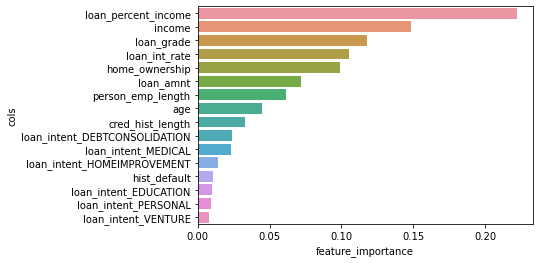

In [40]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(train_prep, y_train)

feat_imp = pd.DataFrame({'cols':train_prep.columns.to_list(), 'feature_importance':rfc.feature_importances_})
sns.barplot(data=feat_imp.sort_values('feature_importance', ascending=False),
            x='feature_importance',
            y='cols')

In [41]:
selected_cols = feat_imp.sort_values('feature_importance', ascending=False).head()['cols'].to_list()
train = train_prep[selected_cols]
test = test_prep[selected_cols]

In [42]:
selected_cols

['loan_percent_income',
 'income',
 'loan_grade',
 'loan_int_rate',
 'home_ownership']

## **Pipeline**

In [43]:
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler())])

ord_pipe = Pipeline([('ord_enc', OrdinalEncoder(categories=[['OTHER', 'RENT', 'OWN', 'MORTGAGE'],
                                 ['A', 'B', 'C', 'D', 'E', 'F', 'G']]))])

ohe_pipe = Pipeline ([('ohe_enc', OneHotEncoder(sparse=False))])

full_prep = ColumnTransformer([('num', num_pipe, ['loan_percent_income', 'income', 'loan_int_rate']),
                               ('ord', ord_pipe, ['home_ownership', 'loan_grade'])])

full_pipe = Pipeline([('prep', full_prep),
                      ('model', RandomForestClassifier(random_state=0))])

full_imbhandling = imbpipe([
            ('preprocess', full_prep),
            ('over_sampl', SMOTENC([3, 4], sampling_strategy=0.9, random_state=0)),
            ('model', RandomForestClassifier(random_state=0))
])

## **Model without Imbalance Handling**

In [44]:
# # without imbalance handling
# params = [
#     {'model__n_estimators': [40, 70, 100],        # 3
#      'model__max_features': [2, 5],            # 2
#      'model__max_depth': [5, 10, None],              # 3
#      'model__criterion': ['gini', 'entropy']},       # 2   Total 3*2*3*2 = 36 combinations
#   ]

# rfc = RandomForestClassifier(random_state=0)

# grid_search = GridSearchCV(full_pipe, params, cv=5,
#                            scoring='f1',
#                            return_train_score=True)
# grid_search.fit(X_train, y_train)

In [45]:
# # without imbalance handling
# model = grid_search.best_estimator_

# # model.fit(train, y_train)

# model_train = model.predict(X_train)
# model_test = model.predict(X_test)

# print(classification_report(y_train, model_train))
# print(classification_report(y_test, model_test))

## **Model with Imbalance Handling**

In [46]:
# with imbalance handling
params = [
    {'model__n_estimators': [70],        # 4
     'model__max_features': [2, 5],            # 4
     'model__max_depth': [10, None],              # 3
     'model__criterion': ['gini', 'entropy']},       # 2   Total 4*4*3*2 = 96 combinations
  ]

rfc = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(full_imbhandling, params, cv=5,
                           scoring='f1',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['loan_percent_income',
                                                                          'income',
                                                                          'loan_int_rate']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord_enc',
                                                                                          OrdinalEncoder(categories=[['OTHER',
                                                                                                                      'RENT',
                                                                                                                      'OWN',
                                                                                                                      'MORTGAGE'],
                                                                                                                     ['A',
                                                                                                                      'B',
                                                                                                                      'C',
                                                                                                                      'D',...
                                                                                                                      'G']]))]),
                                                                         ['home_ownership',
                                                                          'loan_grade'])])),
                                       ('over_sampl',
                                        SMOTENC(categorical_features=[3, 4],
                                                random_state=0,
                                                sampling_strategy=0.9)),
                                       ('model',
                                        RandomForestClassifier(random_state=0))]),
             param_grid=[{'model__criterion': ['gini', 'entropy'],
                          'model__max_depth': [10, None],
                          'model__max_features': [2, 5],
                          'model__n_estimators': [70]}],
             return_train_score=True, scoring='f1')

In [47]:
grid_search.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_percent_income',
                                                   'income', 'loan_int_rate']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord_enc',
                                                                   OrdinalEncoder(categories=[['OTHER',
                                                                                               'RENT',
                                                                                               'OWN',
                                                                                               'MORTGAGE'],
                                                                                              ['A',
                                                                                               'B',
                                                                                               'C',
                                                                                               'D',
                                                                                               'E',
                                                                                               'F',
                                                                                               'G']]))]),
                                                  ['home_ownership',
                                                   'loan_grade'])])),
                ('over_sampl',
                 SMOTENC(categorical_features=[3, 4], random_state=0,
                         sampling_strategy=0.9)),
                ('model',
                 RandomForestClassifier(max_depth=10, max_features=2,
                                        n_estimators=70, random_state=0))])

In [48]:
# with imbalance handling
model = grid_search.best_estimator_

# model.fit(train, y_train)

model_train = model.predict(X_train)
model_test = model.predict(X_test)

print(classification_report(y_train, model_train))
print(classification_report(y_test, model_test))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     17729
           1       0.78      0.77      0.78      4962

    accuracy                           0.90     22691
   macro avg       0.86      0.85      0.86     22691
weighted avg       0.90      0.90      0.90     22691

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7598
           1       0.76      0.74      0.75      2127

    accuracy                           0.89      9725
   macro avg       0.84      0.84      0.84      9725
weighted avg       0.89      0.89      0.89      9725



# **Model Explainibility**

## **SHAP**

I am not sure, but I think SHAP not yet support input type pipeline with imbalance handling. so, we will preprare the X_train manually.

In [49]:
err

NameError: name 'err' is not defined

In [50]:
model['preprocess']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['loan_percent_income', 'income',
                                  'loan_int_rate']),
                                ('ord',
                                 Pipeline(steps=[('ord_enc',
                                                  OrdinalEncoder(categories=[['OTHER',
                                                                              'RENT',
                                                                              'OWN',
                                                                              'MORTGAGE'],
                                                                             ['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'F',
                                                                              'G']]))]),
                                 ['home_ownership', 'loan_grade'])])

In [51]:
# preprocess
shap_train = pd.DataFrame(model['preprocess'].transform(X_train), columns=model['preprocess'].get_feature_names_out())
shap_test = pd.DataFrame(model['preprocess'].transform(X_test), columns=model['preprocess'].get_feature_names_out())

# # balancing on train
# imb = pd.DataFrame(SMOTENC([3, 4], sampling_strategy=0.9, random_state=0))
# shap_X_train, shap_y_train = imb.fit_tranform(shap_train, y_train)

# model for shap
shap_model = model['model']

In [52]:
explainer = shap.TreeExplainer(shap_model)

In [53]:
shap_values = explainer.shap_values(shap_train)

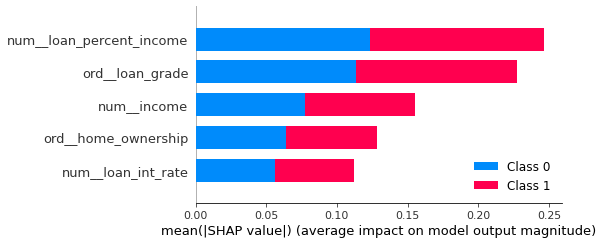

In [61]:
shap.summary_plot(shap_values, shap_train)

In [64]:
explainer.expected_value

array([0.52584533, 0.47415467])

In [68]:
shap_values[1][0,:]

array([-0.07124898,  0.01715729, -0.01779791, -0.02193308, -0.07238784])

In [69]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], features=shap_train.head(1))

In [71]:
model.predict_proba(X_train.head(1))

array([[0.69205585, 0.30794415]])

In [ ]:
# explainer = shap.TreeExplainer(shap_model, data=shap_train, model_output='probability')
# shap_values = explainer.shap_values(shap_test)

100%|===================| 19413/19450 [05:10<00:00]       

In [ ]:
model.predict_proba(X_test.head(1))

array([[0.83915625, 0.16084375]])

In [ ]:
explainer.expected_value

array([0.70916175, 0.29083825])

In [ ]:
shap_values[1][:,1]

array([-0.05348676, -0.00106329, -0.09391482, ..., -0.10882893,
        0.01351078, -0.10124908])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0][:,1], features=shap_test.head(1))

DimensionError: Length of features is not equal to the length of shap_values!

In [ ]:
shap.summary_plot(shap_values, shap_test, plot_type="bar", color='red')

In [ ]:
explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(shap_test.head(1))

In [ ]:
explainer.expected_value

In [ ]:
shap_values[0][:,1]

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0][:,1], shap_test.head(1))

In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(shap_test)
print('Expected Value: ', explainer.expected_value)

In [ ]:
shap.__version__

In [ ]:
# code camp https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability
explainer = shap.Explainer(shap_model)
shap_values = explainer.shap_values(shap_test)

In [ ]:
print('Expected Value: ', explainer.expected_value)
print('shap values shape: ', shap_values.shape)

In [ ]:
shap_test.values

In [ ]:
explainer = shap.Explainer(shap_model)

In [ ]:
shap_values = explainer(shap_test)
shap_values.shape

(9725, 5, 2)

array([-0.11898006, -0.07313335, -0.05000097,  0.01536668, -0.0866226 ])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],shap_values[1][0], shap_test.head(1))